# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import folium
from IPython.display import display
import branca

### Consolidar Base de Dados

In [2]:
meses = {'jan': 1, 'fev': 2, 'mar': 3,'abr': 4,'mai': 5,'jun': 6,'jul': 7,'ago': 8,'set': 9,'out': 10,'nov': 11,'dez': 12}


caminho_bases = pathlib.Path('dataset')
base_airbnb = pd.DataFrame()
for arquivo in caminho_bases.iterdir():
    
    nome_mes = arquivo.name[:3]
    #num mes
    mes = meses[nome_mes]
    ano = arquivo.name[-8:]
    ano = int(ano.replace(".csv",""))
    
    
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = pd.concat([base_airbnb,df],ignore_index=True)
display(base_airbnb)

C:\Users\User\AppData\Local\Temp\ipykernel_13888\1087321060.py:15: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\User\AppData\Local\Temp\ipykernel_13888\1087321060.py:15: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\User\AppData\Local\Temp\ipykernel_13888\1087321060.py:15: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\User\AppData\Local\Temp\ipykernel_13888\1087321060.py:15: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\User\AppData\Local\Temp\ipykernel_13888\1087321060.py:15: DtypeWarning: Columns (61,62,94) have mixed types.

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
902207,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


- Como temos muitas colunas, nosso modelo pode acabar ficando lento.
- Além disso, fazendo uma análise rápida foi possibilitado a identificação de que várias colunas não são necessárias para o modelo de previsão, por isso, serão exclusas da base.
- Tipos de colunas que serão excluídas:
    1. Id's links e informações não relevantes para o modelo.
    2. Colunas repetidas ou extremamente parecidas com outra (dão a mesma info para o modelo Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre, não será preciso
    4. Colunas em que todos ou quase todos os valores são iguais
- Para isso, será criado um arquivo excel com os 1.000 primeiros registros para que seja feita uma análise qualitativa.
- Note que as mudanças foram no sentido de deixar somente colunas que impactam no preço da diária.

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

- Gerar os primeiros mil arquivos em csv para identificar as colunas que serão excluidas

In [3]:
print(list(base_airbnb.columns))

base_airbnb.head(1000).to_csv('primeiros_resgistros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

###  Depois da análise qualitativa  das colunas, levando em conta os critérios acima aplicados, as colunuas ficaram assim:

In [4]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']
base_airbnb = base_airbnb.loc[:,colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902206,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902207,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
902208,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Tratar Valores Faltando

- Visualizando os dados, constatou-se que existia uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise.

- Para as outras colunas, foram excluídas apenas as linhas NaN (haja vista que temos mais de 900 k de linhas)


In [5]:


for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna,axis=1)


base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [6]:
print(base_airbnb.dtypes)
print('-' * 75)
print(base_airbnb.iloc[0])



host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
---------------------------------------------------------------------------
host_is_superhost                                                           f
host

- Como o preço e preço extra por pessoa estão reconhecidos como Objeto, alteramos as colunas para aparecerem como float

In [7]:
#price
try:
    base_airbnb['price'] = base_airbnb['price'].str.replace('$', '').str.replace(',', '')
    base_airbnb['price'] = base_airbnb['price'].astype(np.float64, copy=False)
    
    base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '').str.replace(',', '')
    base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float64, copy=False)
except:
    print('As variáveis já foram convertidas em Float64!')

print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float64
guests_included               int64
extra_people                float64
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

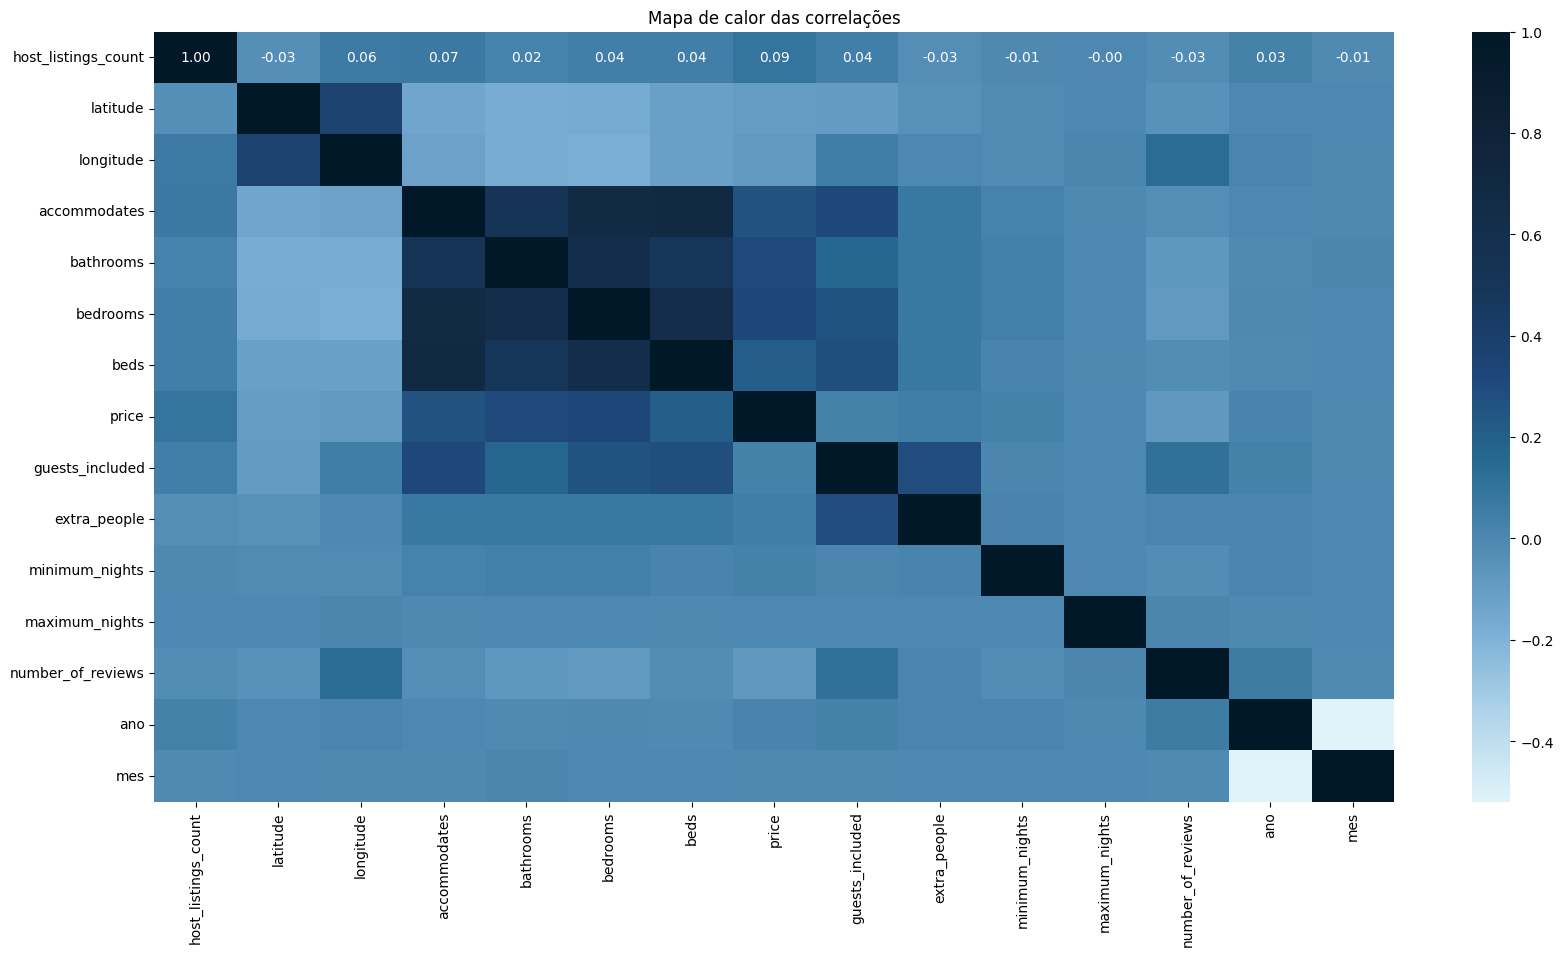

In [8]:


# Criar uma tabela só com valores numéricos
numericos = base_airbnb.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação
correlation_matrix = numericos.corr()



# Criar o colormap personalizado
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", [
    "#e0f3f9",  # Azul muito claro, quase branco
    "#b0d4ea",  # Azul claro
    "#7aaed4",  # Azul médio
    "#4f8ab3",  # Azul suave
    "#266890",  # Azul escuro
    "#1E4678",  # Azul principal
    "#163659",  # Azul escuro, tom complementar
    "#122b46",  # Azul muito escuro
    "#0f2034",  # Azul quase preto
    "#001827"   # Tom mais profundo, próximo ao preto
])

plt.figure(figsize=(20, 10))
plt.title("Mapa de calor das correlações")

# Criar o mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, fmt=".2f", cbar=True)

plt.show()


### Definição de Funções para Análise de Outliers
-Vamos definir alguma funções para ajudar na análise de outliers das colunas

In [9]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

In [10]:
def diagrama_caixa(coluna):
    fig,(ax1, ax2) = plt.subplots(1,2)
    
    #tamanho dos graficos
    fig.set_size_inches(15,5)
    
    
    #grafico 1 com limite automatico
    sns.boxplot(x=coluna,ax = ax1)
    
    #limite do segundo boxplot
    ax2.set_xlim(limites(coluna))
    
    sns.boxplot(x=coluna,ax = ax2)

def histograma(coluna):
    #configuração de tamanho para 1 grafico
    plt.figure(figsize=(15,5))
    sns.histplot(coluna, kde=True) 
    
def excluir_outliers(df,nome_coluna):
    qtde_linhas = df.shape[0]
    lim_if, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_if) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index,y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

In [11]:
print(limites(base_airbnb['price']))
base_airbnb['price'].describe()

(-524.0, 1276.0)


count    897709.000000
mean        647.922333
std        1705.998135
min           0.000000
25%         151.000000
50%         297.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64

### PRICE


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


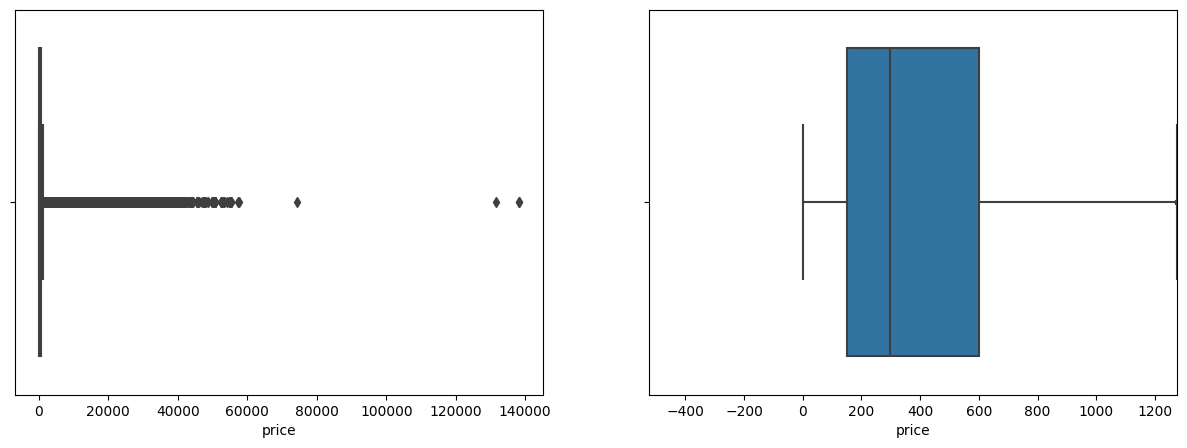

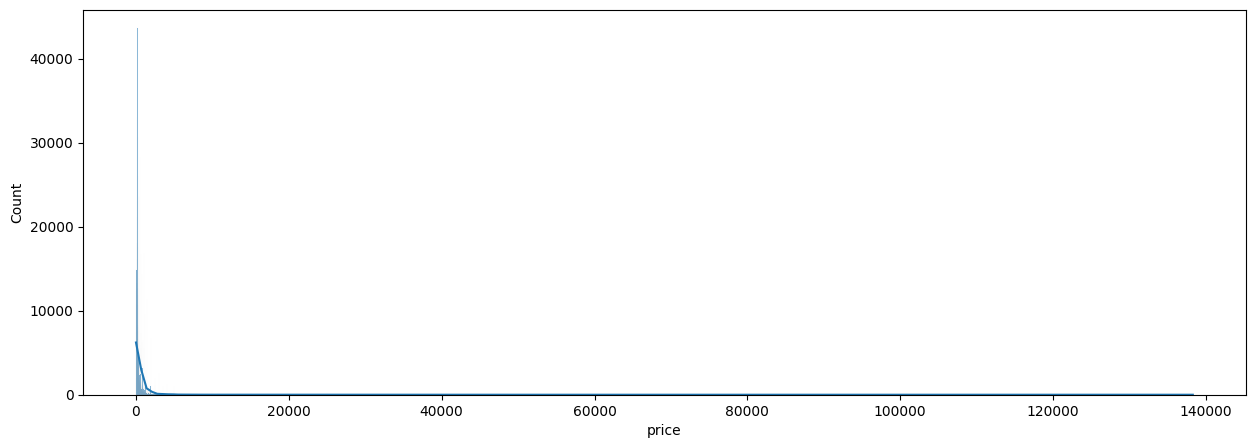

In [12]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

- Como o modelo é realizado para apartamentos comuns, entendo que as diárias acima do limite superior serão apenas para
apartamentos de altíssimo padrão, que não é nosso caso, por isso podemos exclui-los.

In [13]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


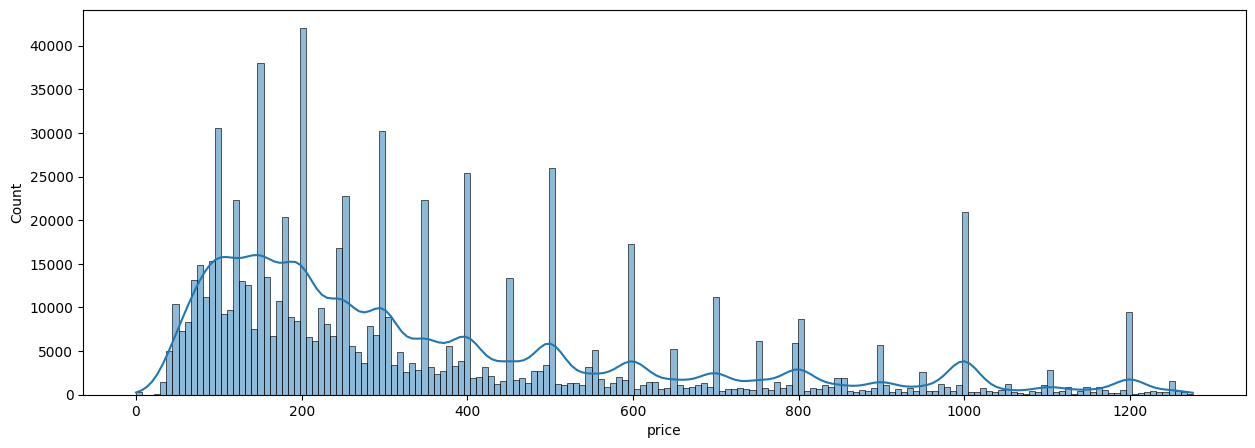

In [14]:
histograma(base_airbnb['price'])

### Extra people

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


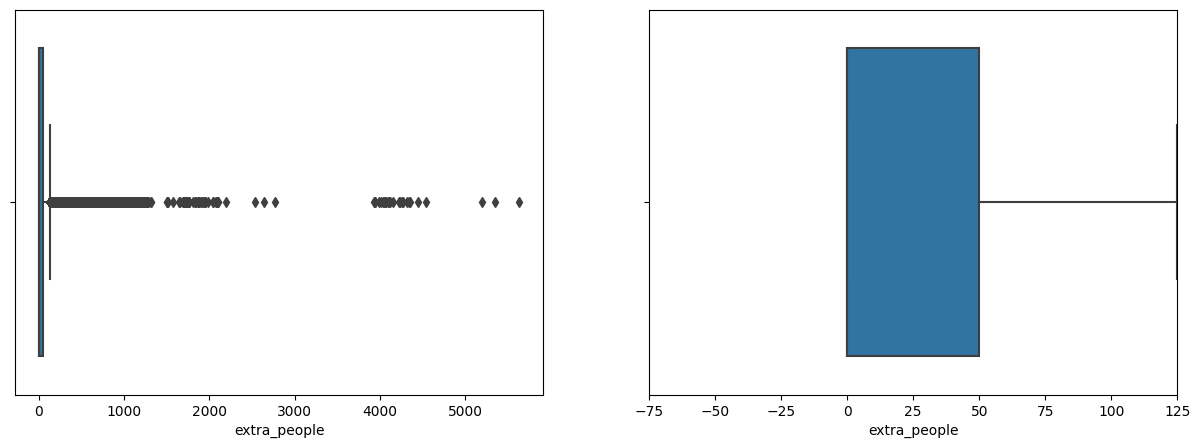

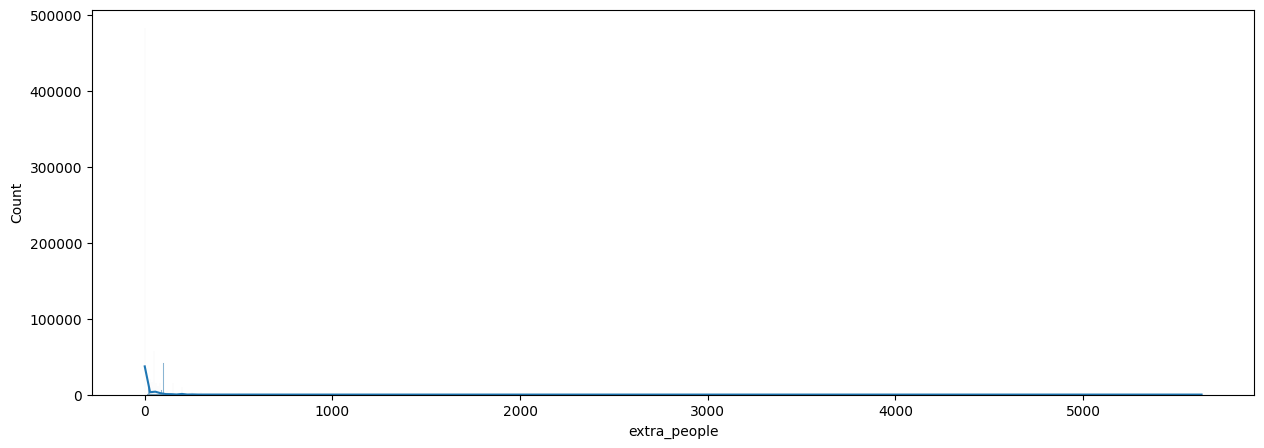

In [15]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [16]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


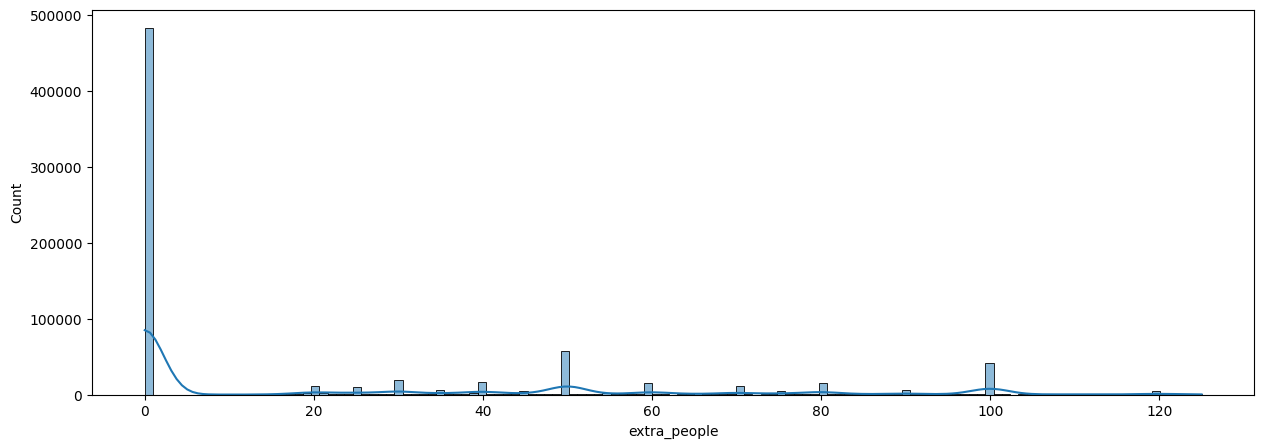

In [17]:
histograma(base_airbnb['extra_people'])

### host_listings_count   

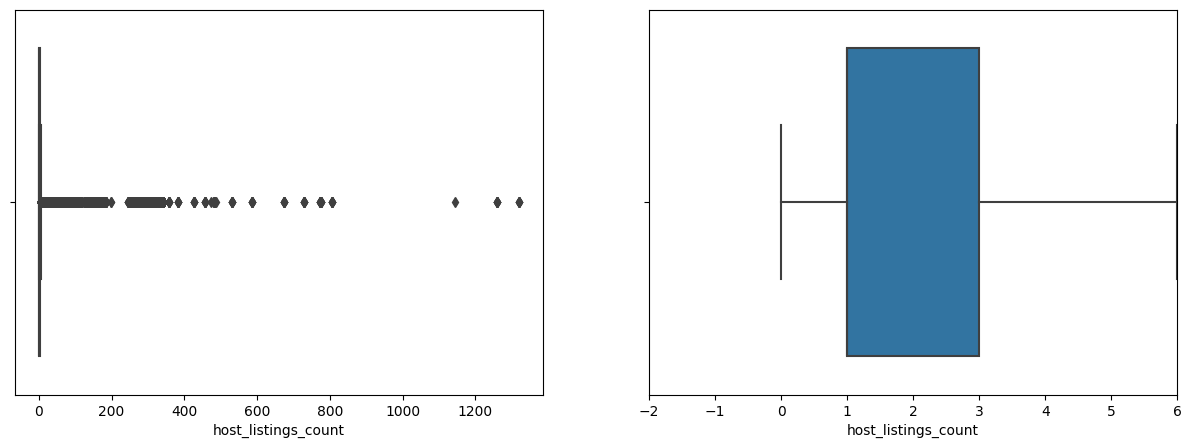

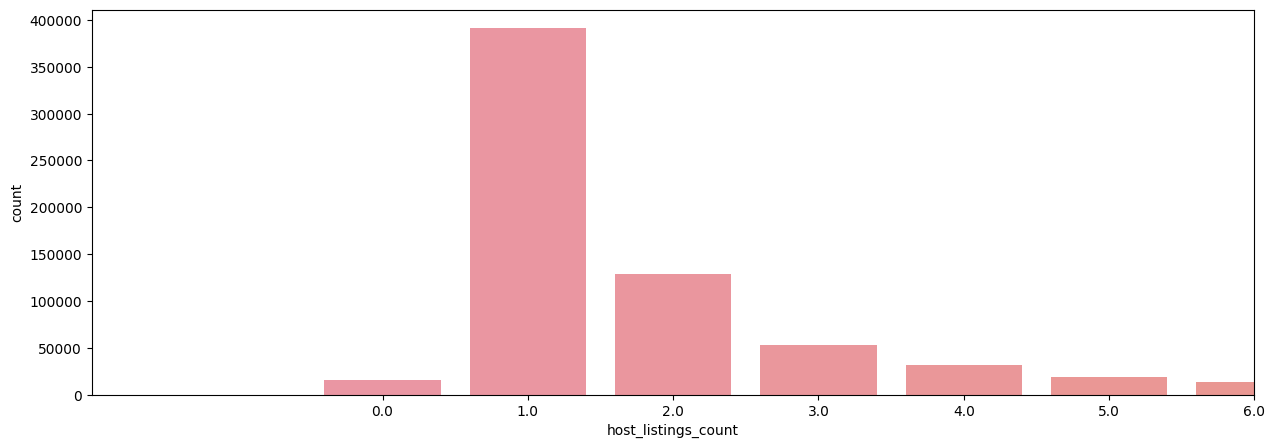

In [18]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

- Exclui os outliers, porque para o objetivo do projeto hosts com mais de 6 imoveis no airbnb não são o público alvo.

In [19]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


### accommodates

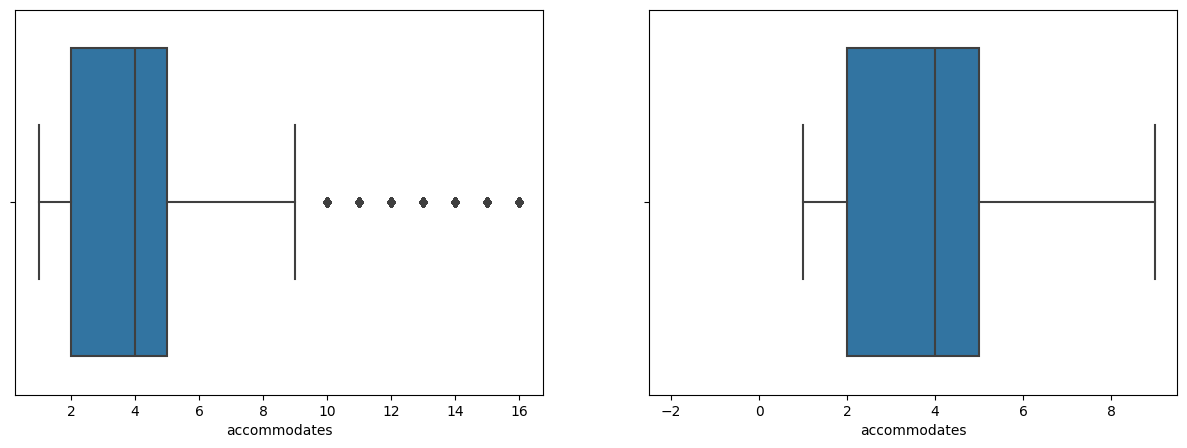

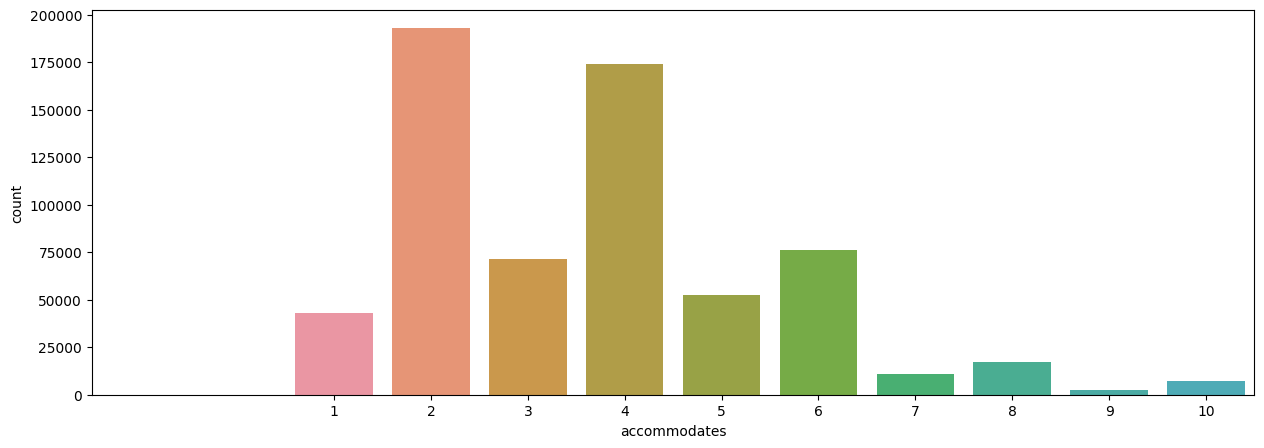

In [20]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### bathrooms 

<Axes: xlabel='bathrooms', ylabel='count'>

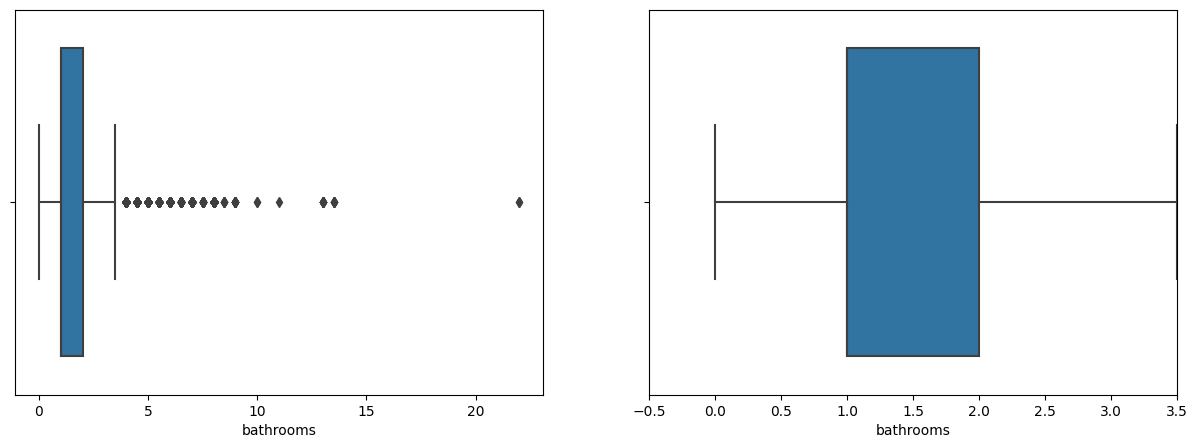

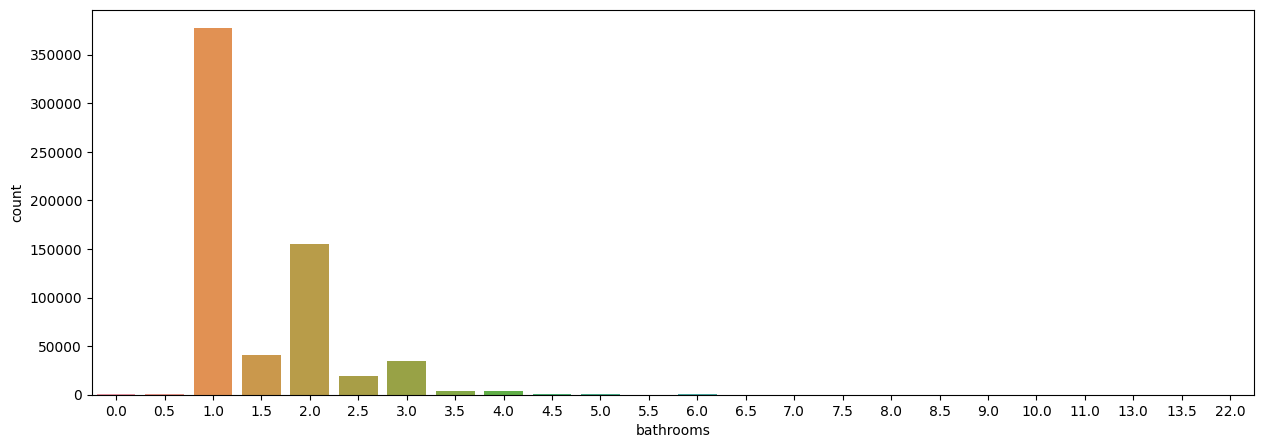

In [22]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index,y=base_airbnb['bathrooms'].value_counts())

In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### bedrooms 

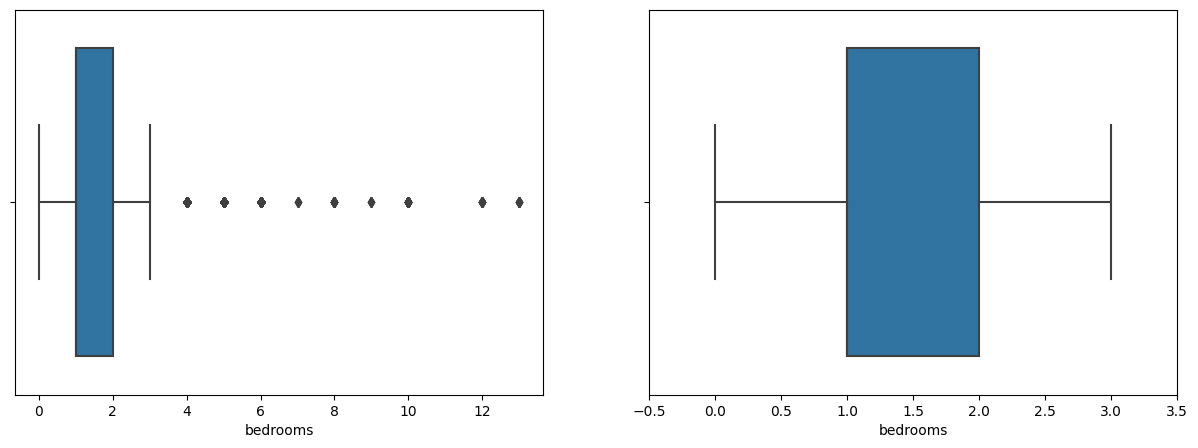

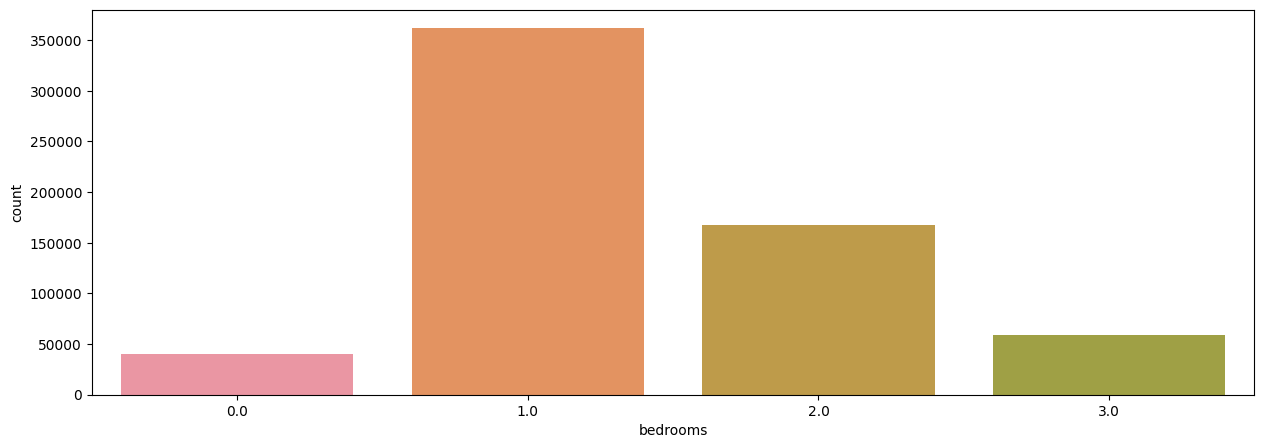

In [24]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### Beds

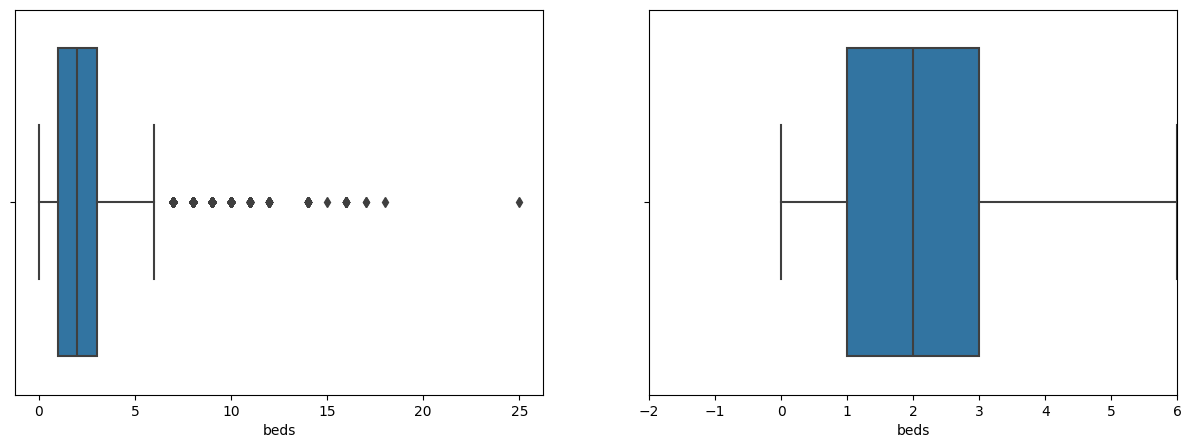

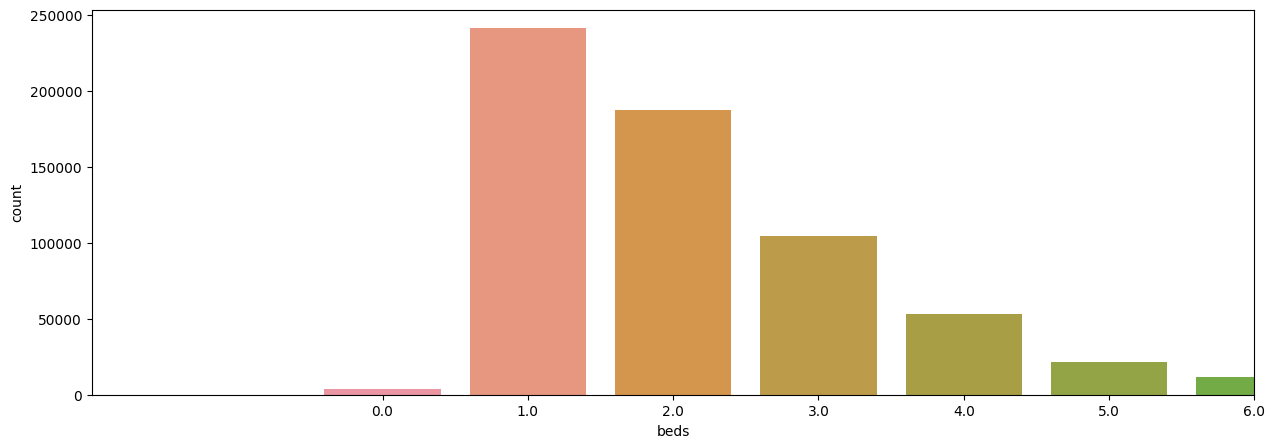

In [26]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [27]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### guests_included  

In [28]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))

(1.0, 1.0)


- Vamos remover essa feature da análise, há indícios de que os hosts do airbnb adotam como padrão informar 1 ou não informar guest included. Assim pode levar o modelo a considerar essa feature, como explicado ela não é essencial para a definição de preço.

In [29]:
try:
    base_airbnb = base_airbnb.drop('guests_included',axis=1)
except:
    print('guests_included já excluída')
base_airbnb.shape

(622366, 22)

### minimum_nights

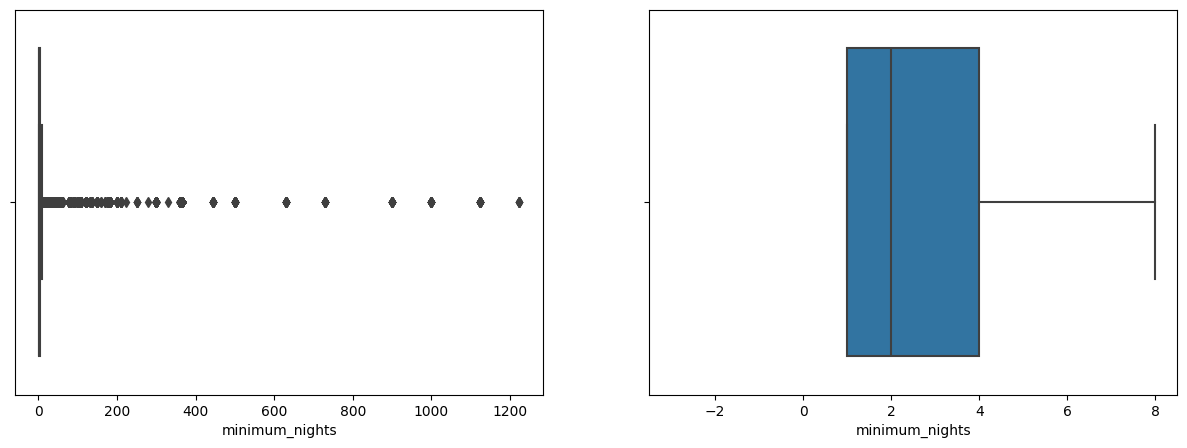

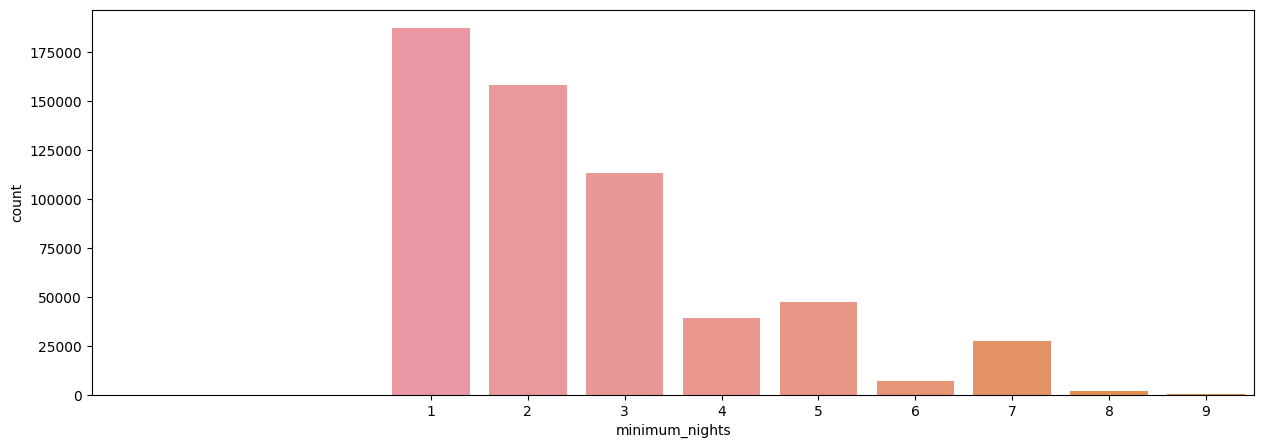

In [30]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [31]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### maximum_nights

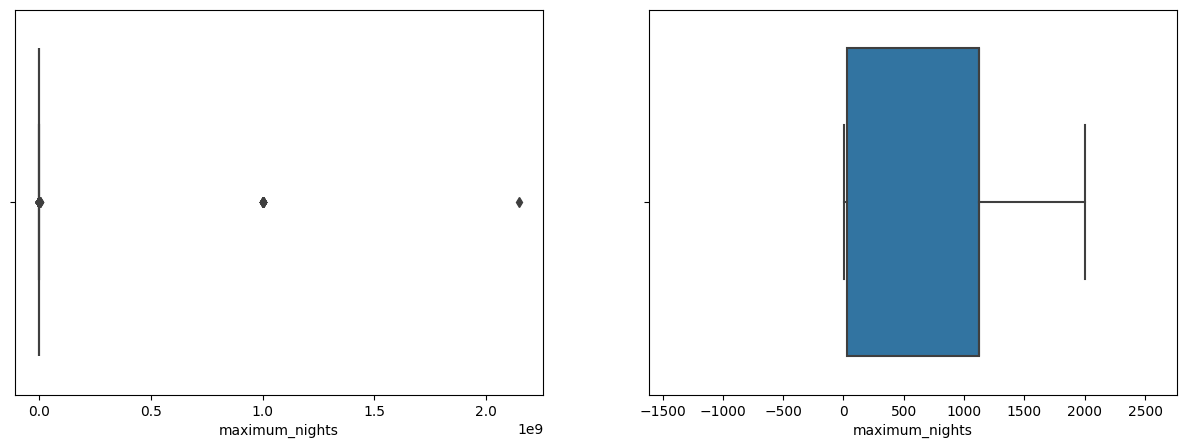

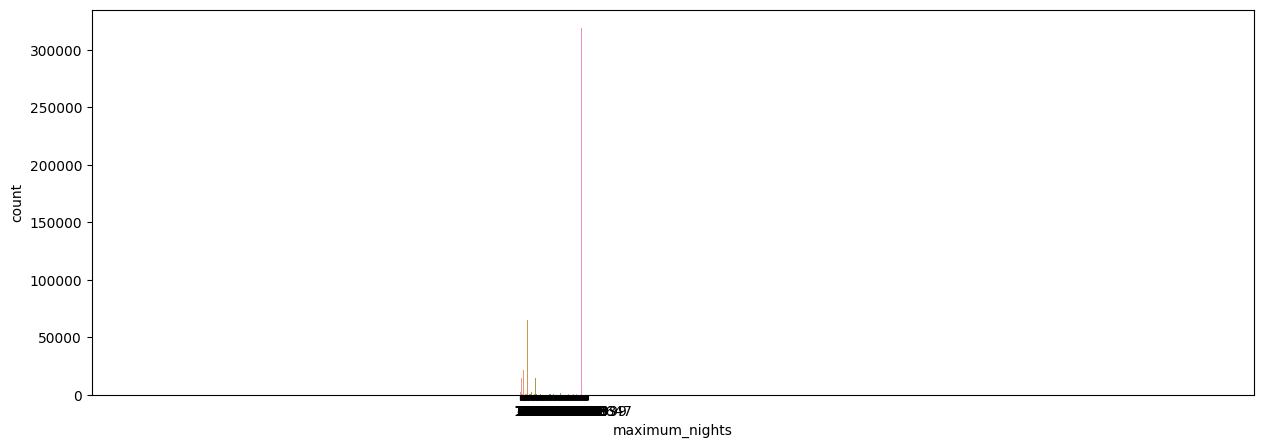

In [32]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Vamos remover essa feature da análise, há indícios de que os hosts do airbnb adotam como padrão informar 0 ou um numero muito acima como maximo de noites. 
Assim pode levar o modelo a considerar essa feature,como explicado ela não é essencial para a definição de preço.

In [33]:
try:
    base_airbnb = base_airbnb.drop('maximum_nights',axis=1)
except:
    print('maximum_nights já excluída')
base_airbnb.shape

(581983, 21)

### number_of_reviews                  


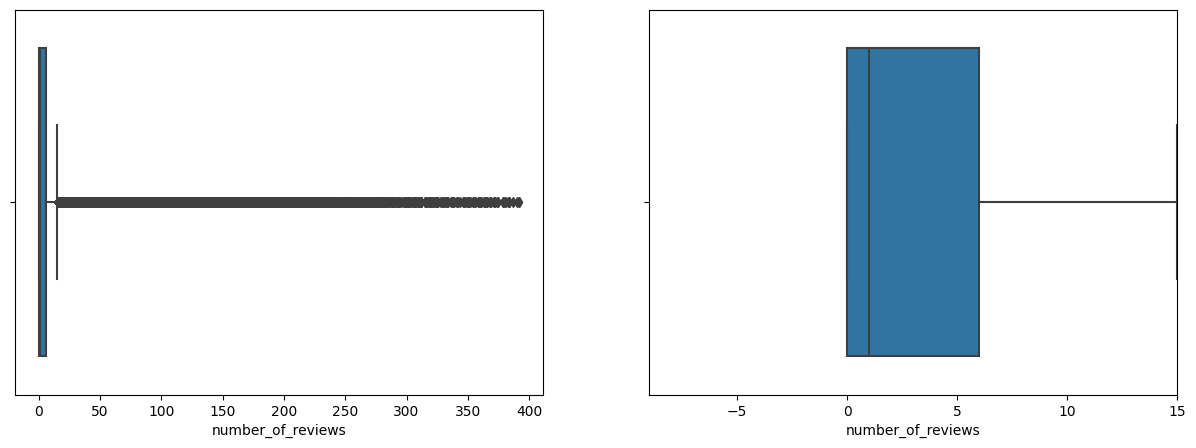

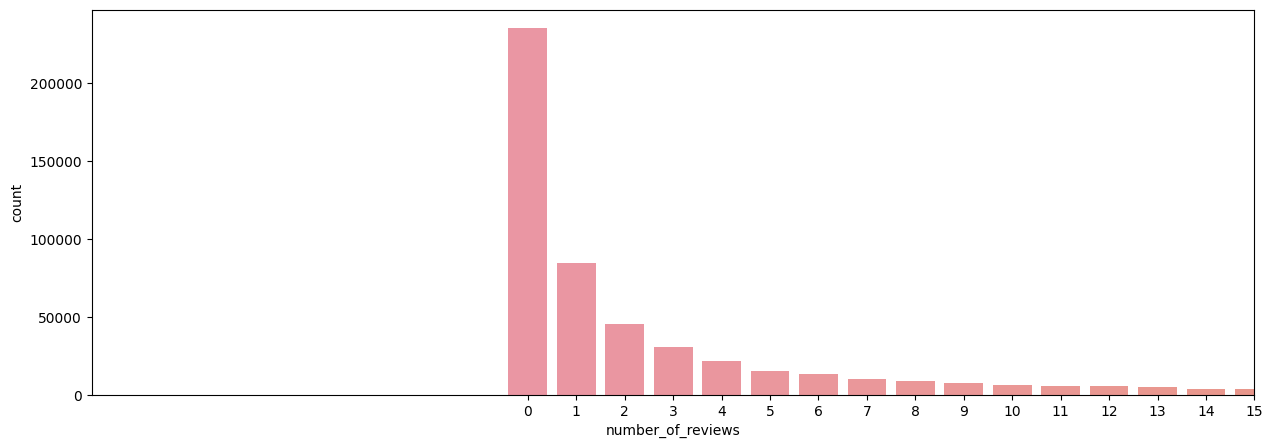

In [34]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [35]:
try:
    base_airbnb = base_airbnb.drop('number_of_reviews',axis=1)
except:
    print('number_of_reviews já excluída')
base_airbnb.shape

(581983, 20)

### Tratamento de colunas de texto

### property_type 

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

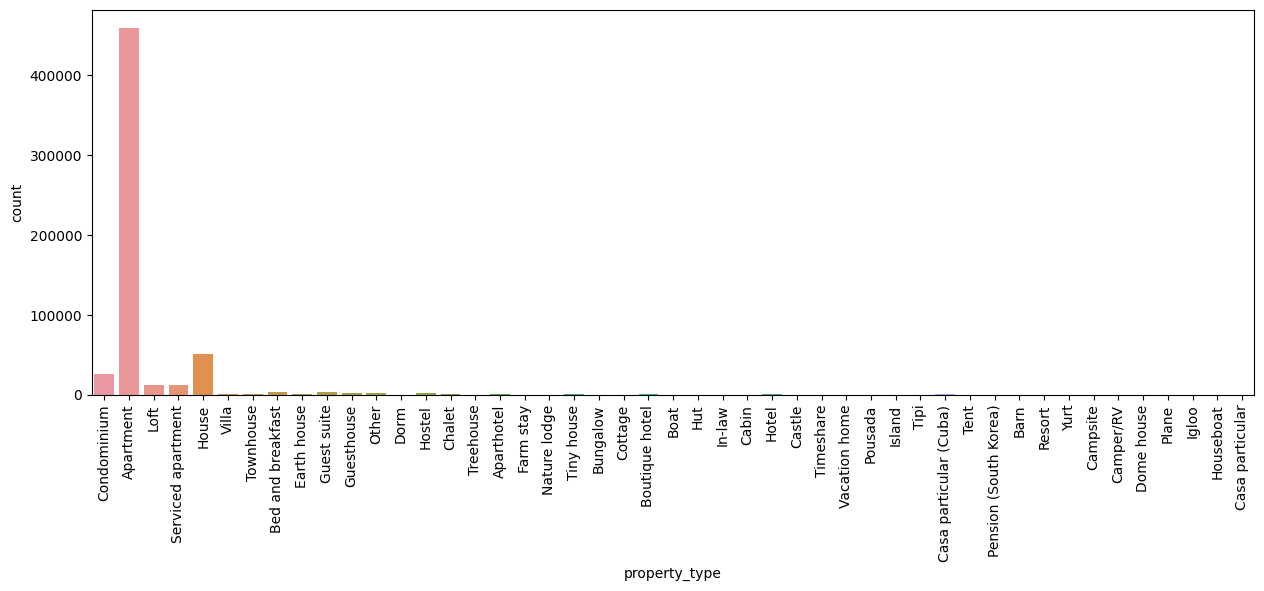

In [36]:
print(base_airbnb['property_type'].value_counts())
print('-'*254)
plt.figure(figsize=(15,5))
sns.countplot(x='property_type',data=base_airbnb)
plt.xticks(rotation=90)
plt.show()

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

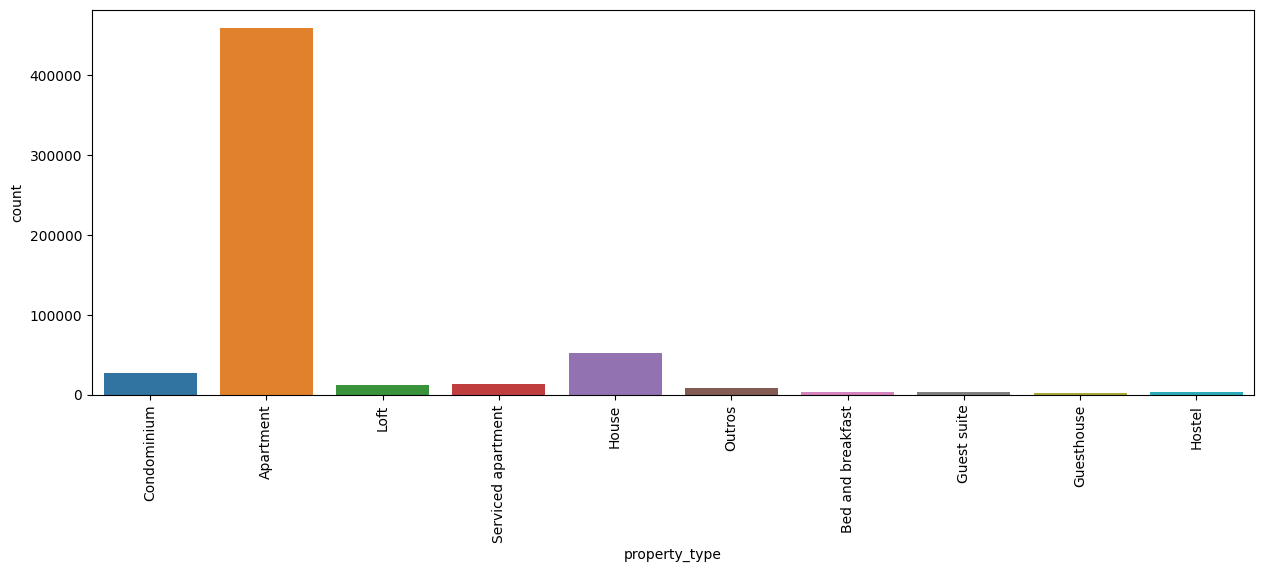

In [37]:
tipos_casa = base_airbnb['property_type'].value_counts()

outras = []

for tipo in tipos_casa.index:
    if tipos_casa[tipo] < 2000:
        outras.append(tipo)
print(outras)
        
    
for tipo in outras:
    base_airbnb.loc[base_airbnb['property_type'] ==tipo,'property_type'] = 'Outros'
print(base_airbnb['property_type'].value_counts())
print('-'*254)
plt.figure(figsize=(15,5))
sns.countplot(x='property_type',data=base_airbnb)
plt.xticks(rotation=90)
plt.show()

###  room_type

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


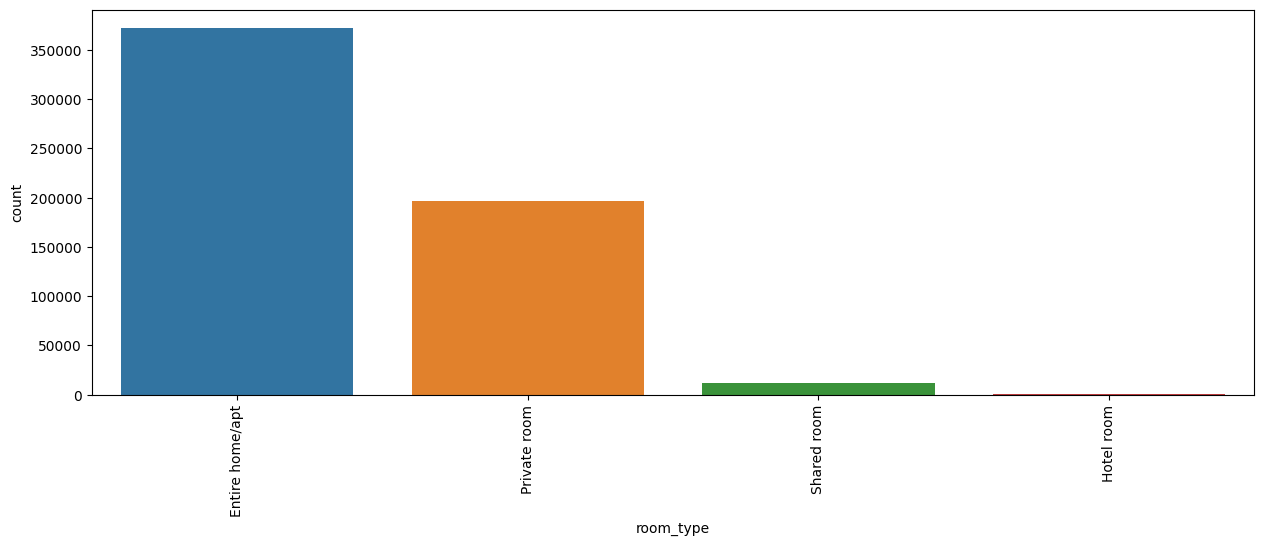

In [38]:
print(base_airbnb['room_type'].value_counts())
print('-'*254)
plt.figure(figsize=(15,5))
sns.countplot(x='room_type',data=base_airbnb)
plt.xticks(rotation=90)
plt.show()

- Em tipo de quarto, não precisamos fazer nada, ele já parece estar bem distribuído

### bed_type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


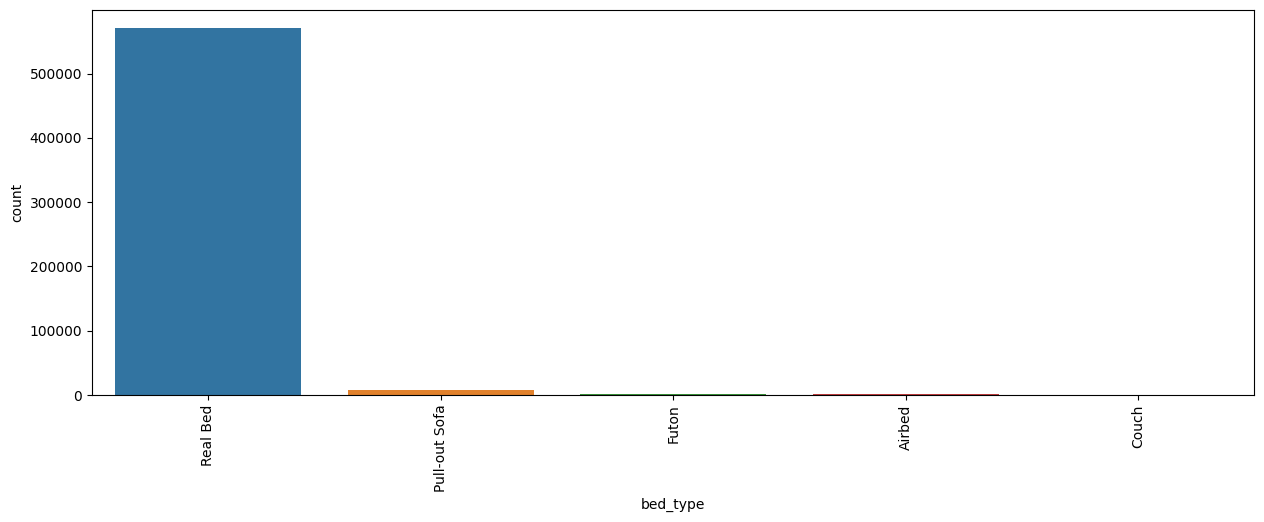

In [39]:
print(base_airbnb['bed_type'].value_counts())
print('-'*254)
plt.figure(figsize=(15,5))
sns.countplot(x='bed_type',data=base_airbnb)
plt.xticks(rotation=90)
plt.show()

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed    570643
Outros       11340
Name: count, dtype: int64
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


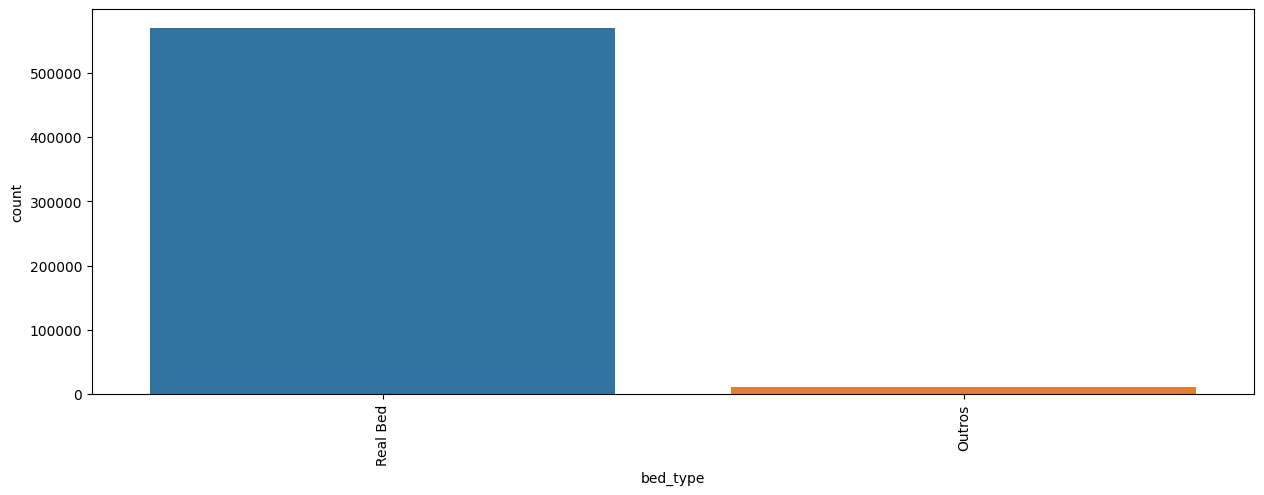

In [40]:
#Agrupando  tipos de cama diferentes de camas reais
tipos_cama = base_airbnb['bed_type'].value_counts()

outras_camas = []

for tipo in tipos_cama.index:
    if tipos_cama[tipo] < 10000:
        outras_camas.append(tipo)
print(outras_camas)
        
    
for tipo in outras_camas:
    base_airbnb.loc[base_airbnb['bed_type'] ==tipo,'bed_type'] = 'Outros'
print(base_airbnb['bed_type'].value_counts())
print('-'*254)
plt.figure(figsize=(15,5))
sns.countplot(x='bed_type',data=base_airbnb)
plt.xticks(rotation=90)
plt.show()

### cancellation_policy 

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


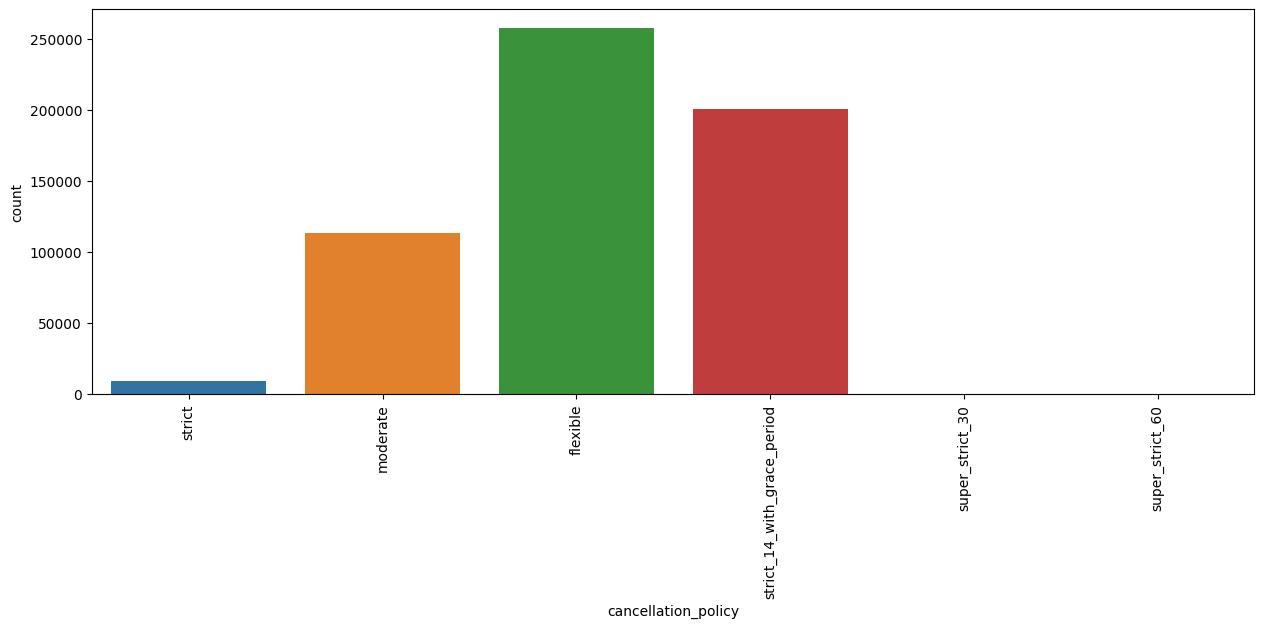

['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


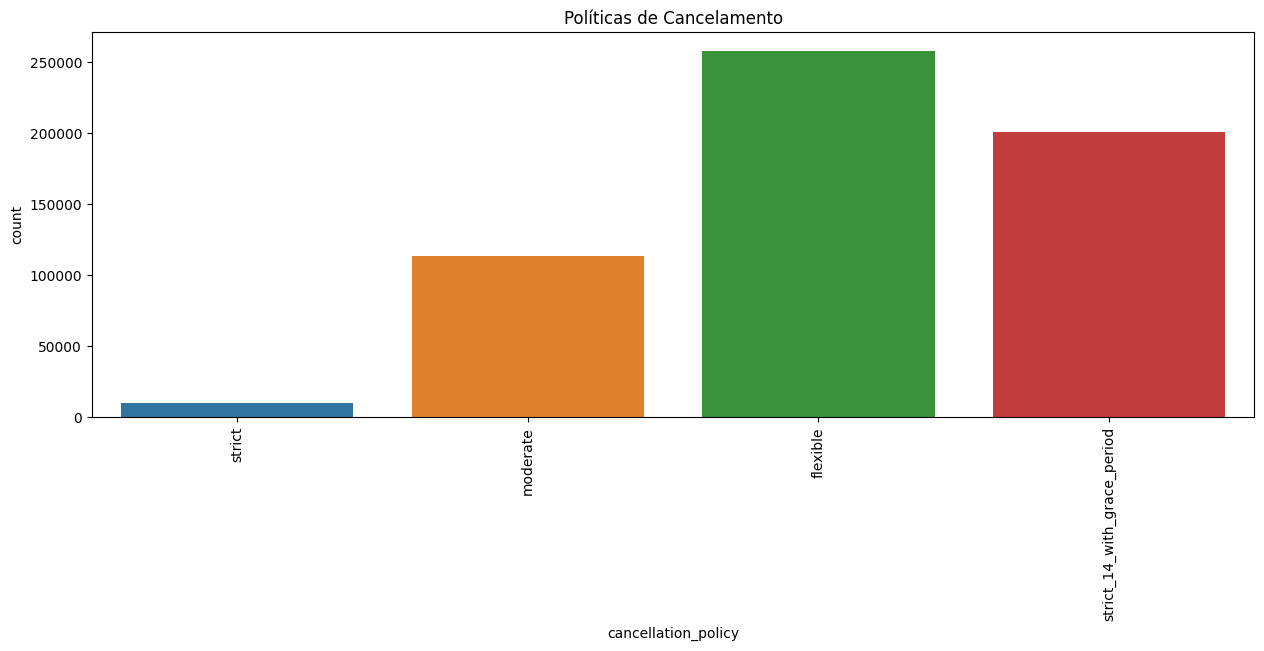

In [41]:
print(base_airbnb['cancellation_policy'].value_counts())
print('-'*254)
plt.figure(figsize=(15,5))
sns.countplot(x='cancellation_policy',data=base_airbnb)
plt.xticks(rotation=90)
plt.show()

#Agrupando as politicas estritas
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
outras_politicas = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        outras_politicas.append(tipo)
print(outras_politicas)
        
    
for tipo in outras_politicas:
    base_airbnb.loc[base_airbnb['cancellation_policy'] ==tipo,'cancellation_policy'] = 'strict'
print(base_airbnb['cancellation_policy'].value_counts())
print('-'*254)
plt.figure(figsize=(15,5))
sns.countplot(x='cancellation_policy',data=base_airbnb)
plt.xticks(rotation=90)
plt.title("Políticas de Cancelamento")
plt.show()

### amenities


+ Como temos uma diversidade muito grande de amenities e, às vezes, os mesmos amenities podem ser escritos de diferentes formas, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.
- A lógica que talvez possa ser usada pelos hosters é quanto mais amenities maior o preço.

In [42]:
print(base_airbnb['amenities'].iloc[3].split(','))
print(len((base_airbnb['amenities'].iloc[3].split(','))))

#Criar a coluna quantidade de amenities por imovel
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', '"Wheelchair accessible"', 'Kitchen', 'Doorman', 'Elevator', '"Free street parking"', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Washer', 'Essentials', 'Shampoo', 'Hangers', '"Hair dryer"', 'Iron', '"Self check-in"', 'Lockbox', '"Hot water"', '"Bed linens"', 'Microwave', 'Refrigerator', '"Dishes and silverware"', '"Cooking basics"', 'Oven', 'Stove', '"Long term stays allowed"', '"Cleaning before checkout"}']
30


In [43]:
#Excluir a coluna amenities.
try:
    base_airbnb = base_airbnb.drop('amenities',axis=1)
except:
    print('Coluna amenities já excluída!')
#visualizar o novo tamanho da base de dados
base_airbnb.shape

(581983, 20)

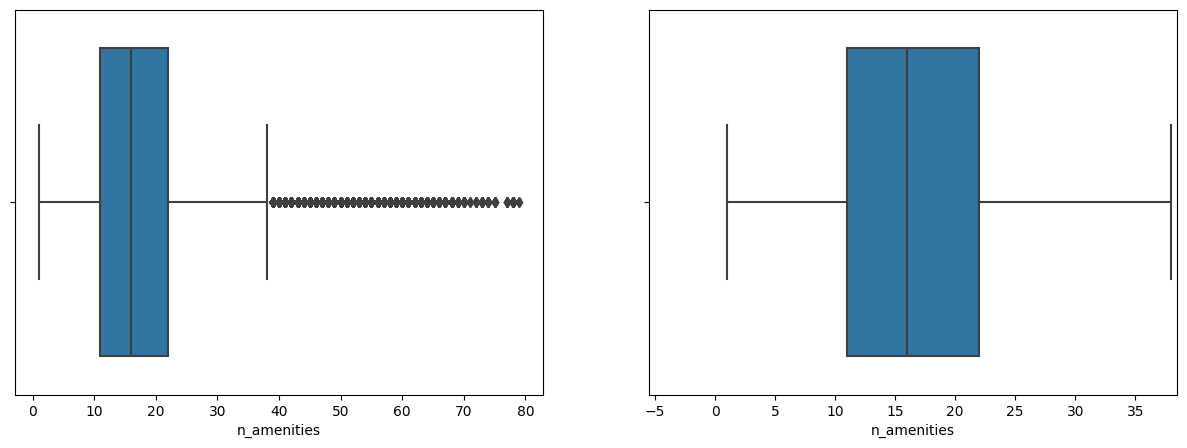

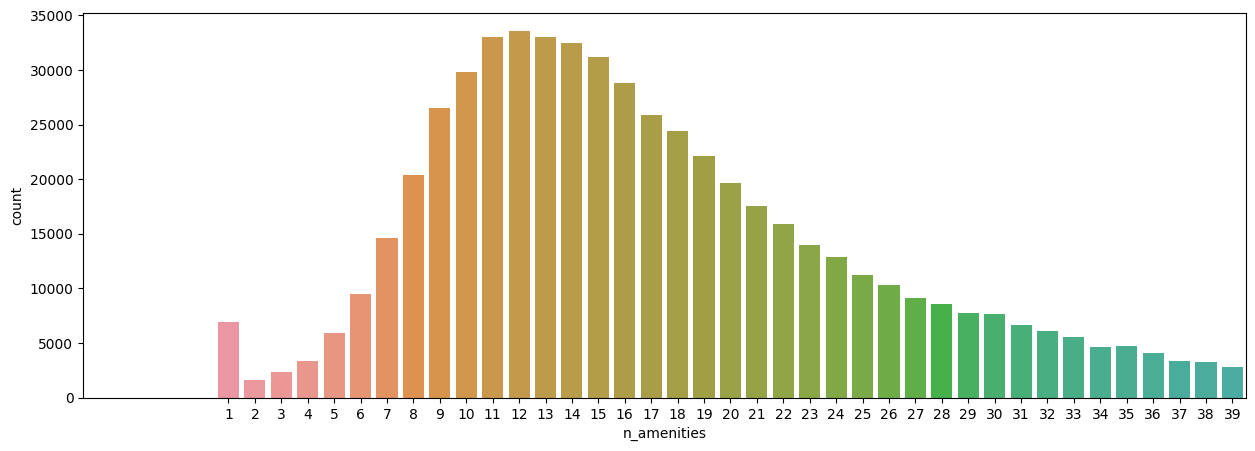

In [44]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

24343 linhas removidas


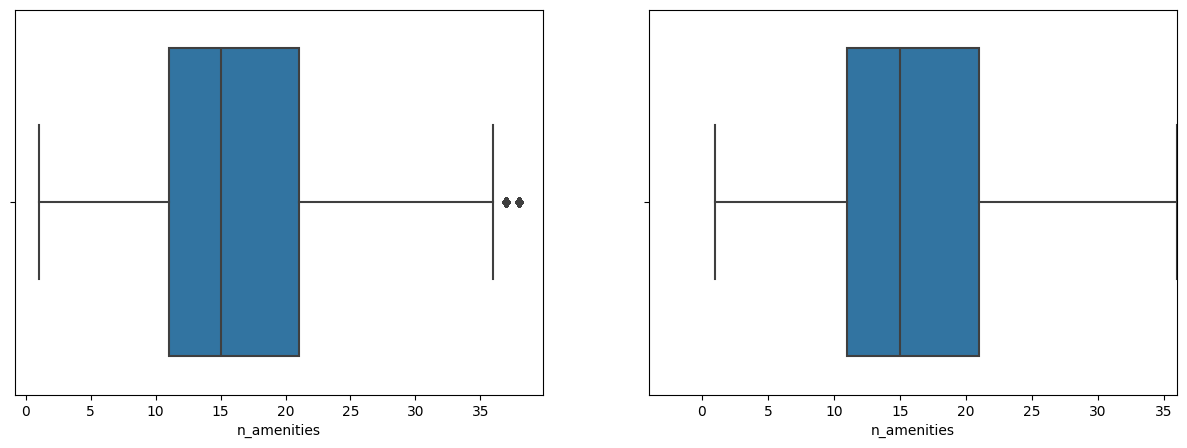

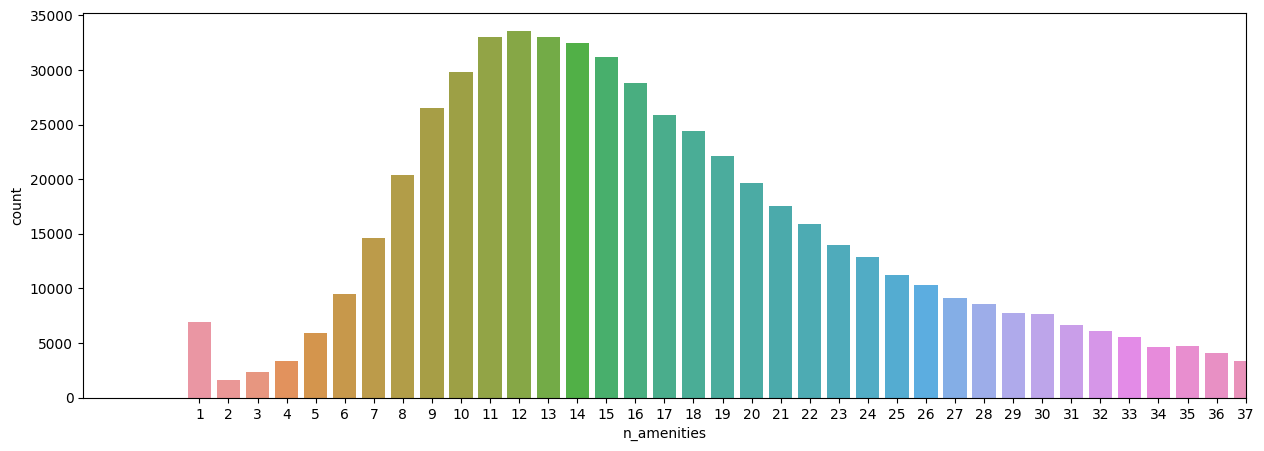

In [45]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

### Visualização de Mapa das Propriedades

In [58]:

amostra = base_airbnb.sample(n=50000)
# Criar o mapa centrado em uma coordenada
centro_mapa = [amostra.latitude.mean(), amostra.longitude.mean()]
mapa = folium.Map(location=centro_mapa, zoom_start=10)

# Função para definir a cor com base no preço
def get_color(price):
    if price <= 200:
        return 'blue'
    elif 201 <= price <= 400:
        return 'lightgreen'
    elif 401 <= price <= 800:
        return 'darkgreen'
    elif 801 <= price <= 1000:
        return 'yellow'
    elif 1001 <= price <= 1300:
        return 'red'
    else:
        return 'Pink'  

# Adicionar pontos de calor no mapa com as cores personalizadas
for _, row in amostra.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=5, 
                        color=get_color(row['price']),  # Cor baseada no preço
                        fill=True, fill_color=get_color(row['price']),
                        fill_opacity=0.7).add_to(mapa)

# Salvar o mapa como arquivo HTML
mapa.save("mapa_airbnb.html")





### Encoding

Precisamor Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [47]:
colunas_tf = ['host_is_superhost', 'instant_bookable','is_business_travel_ready']

base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t',coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f',coluna] = 0





In [48]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outros,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,True,False,False,False,False,True,False,False,True,False
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,True,False,False,False,False,True,False,False,True,False
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,True,False,False,False,False,True,False,False,True,False
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,True,False,False,False,False,True,False,False,True,False
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,True,False,False,False,False,True,False,False,True,False


### Modelo de Previsão

- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

In [49]:
def avaliar_modelo(nome_modelo,y_teste, previsao):
    r2 = r2_score(y_teste,previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

Assim, escolhemos esses 3 modelos. Existem dezenas, ou até centenas de modelos diferentes. A medida com que você for aprendendo mais e mais sobre Ciência de Dados, você vai aprender sempre novos modelos e entendendo aos poucos qual o melhor modelo para usar em cada situação.

Mas na dúvida, esses 3 modelos que usamos aqui são muito bons para muitos problemas de Regressão.

In [50]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price',axis=1)

- Separa os dados em treino e teste + Treino do Modelo

Essa etapa é crucial. As Inteligências Artificiais aprendendo com o que chamamos de treino.

Basicamente o que a gente faz é: a gente separa as informações em treino e teste, ex: 10% da base de dados vai servir para teste e 90% para treino (normalmente treino é maior mesmo)

Aí, damos para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços.

Depois que ele aprende, você faz um teste com ele, com os dados de teste, para ver se ela está bom ou não. Analisando os dados de teste você descobre o melhor modelo

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo,y_test, previsao))

Modelo RandomForest:
R²:97.24%
RSME:44.07
Modelo LinearRegression:
R²:32.70%
RSME:217.54
Modelo ExtraTrees:
R²:97.50%
RSME:41.94


### Análise do Melhor Modelo
- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²:97.49%<br>
RSME:42.01

,0
bedrooms,0.118851
latitude,0.104354
longitude,0.101341
n_amenities,0.089798
extra_people,0.085269
bathrooms,0.070008
accommodates,0.069570
minimum_nights,0.064880
room_type_Entire home/apt,0.064046
beds,0.052832


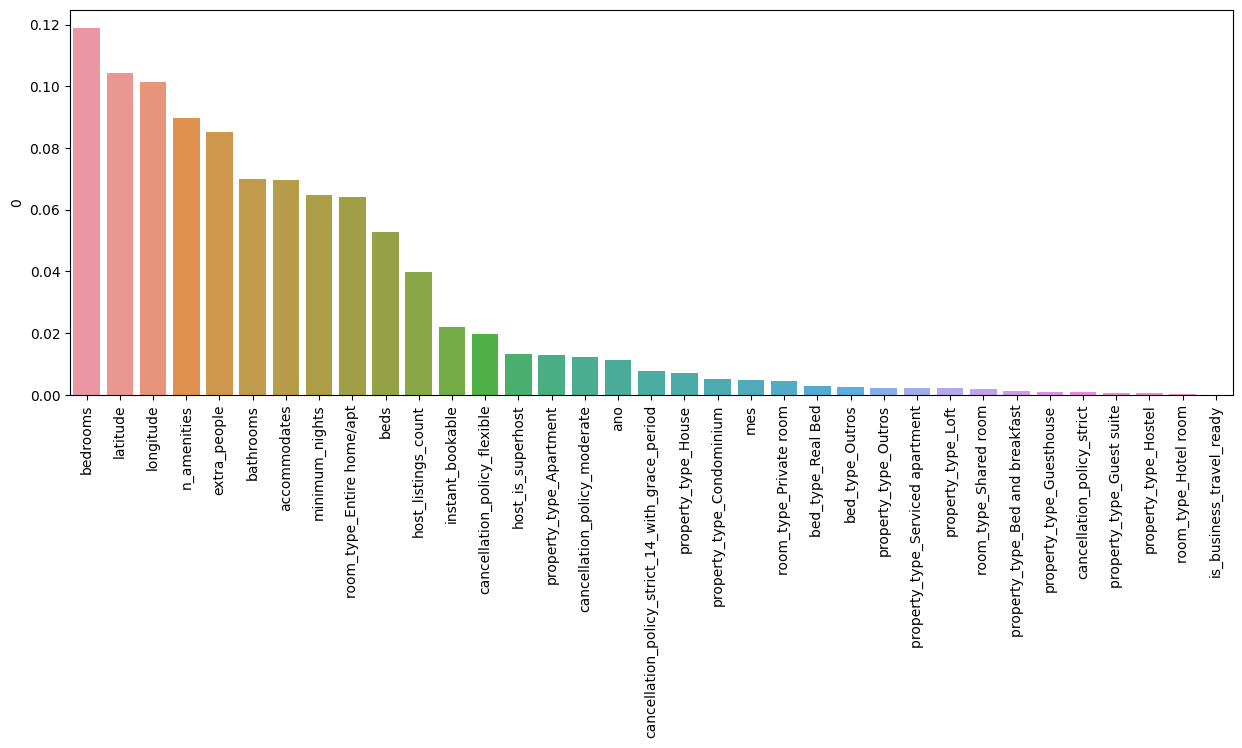

In [52]:
#print(modelo_et.feature_importances_)
#print(X_train.columns)

importancia_features = pd.DataFrame(modelo_et.feature_importances_,X_train.columns)
importancia_features = importancia_features.sort_values(by=0,ascending=False)
display(importancia_features)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index,y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo

- is_business_travel ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [53]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready',axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)


#treinar
modelo_et.fit(X_train, y_train)
#testar
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees',y_test, previsao))

Modelo ExtraTrees:
R²:97.49%
RSME:42.05


In [54]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:    
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)


#treinar
modelo_et.fit(X_train, y_train)
#testar
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees',y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo ExtraTrees:
R²:97.52%
RSME:41.80


In [55]:
print(previsao)

[100.98 998.52 249.2  ... 125.21 273.02 119.85]


# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)<br>
- Passo 2 -> Escolher a forma de deploy:
    - Arquivo Executável + Tkinter
    - Deploy em Microsite (Flask)
    - Deploy apenas para uso direto Streamlit
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [56]:
X['price'] = y
X.to_csv('dados.csv')

In [57]:
import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']